In [212]:
# https://stackoverflow.com/questions/43599018/is-there-a-way-to-get-matplotlib-path-contains-points-to-be-inclusive-of-boundar
#I do quite like this command in Jupiter notebook:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
#It makes things wider and not waste the space on your screen
import pandas as pd
import importlib
import csv,os
import numpy as np
import pandas as pd
import itertools
import pyproj
import shapely
import copy
from uafgi import gicollections,pdutil

import uafgi.data.w21
importlib.reload(uafgi.data.w21)

<module 'uafgi.data.w21' from '/Users/eafischer2/harn/pismip6/uafgi/uafgi/data/w21.py'>

In [139]:
df = pd.read_pickle('outputs/stability/stability.df')    # many rows
select = pd.read_pickle('outputs/stability/03_select.df')   # Just 23 rows
df = pd.merge(df, select, how='left', on='ns642_key', suffixes=(None,'_DELETEME'))
drops = [x for x in df.columns if x.endswith('_DELETEME')]
df = df.drop(drops, axis=1)
print(len(df))

3864


In [140]:
df.columns

Index(['success', 'error_msg', 'ns481_grid', 'velocity_file', 'year',
       'sigma_max', 'w21_popular_name', 'w21_greenlandic_name', 'w21_coast',
       'w21_category', 'w21_Qr', 'w21_Qf', 'w21_Qm', 'w21_Qs',
       'w21_Qc_inferred', 'w21_qm', 'w21_qf', 'w21_qc', 'w21_mean_depth',
       'w21_min_depth', 'w21_quality_str', 'w21_area_grounded_1992_2017',
       'w21_area_grounded_1992_1997', 'w21_area_grounded_1998_2007',
       'w21_area_grounded_2008_2017', 'w21_mean_fjord_width',
       'w21_length_grounded_1992_2017', 'w21_length_grounded_1992_1997',
       'w21_length_grounded_1998_2007', 'w21_length_grounded_2008_2017',
       'w21_ocean_model_sample_area', 'w21_mean_TF_1992-2017',
       'w21_mean_TF_1992-1997', 'w21_mean_TF_1998-2007',
       'w21_mean_TF_2008-2017', 'w21_subglacial_discharge_1992_2017',
       'w21_subglacial_discharge_1992_1997',
       'w21_subglacial_discharge_1998_2007',
       'w21_subglacial_discharge_2008_2017', 'w21_mean_xsection_area',
       'w21_me

In [109]:
select[['w21_popular_name', 'w21_category', 'w21_mean_undercutting_2008_2017', 'ns481_key', 'retreat_rate']]\
  .sort_values(['w21_category','w21_mean_undercutting_2008_2017'])


,w21_popular_name,w21_category,w21_mean_undercutting_2008_2017,ns481_key,retreat_rate
6,Ussing Br.,CR,0.88,W73.75N,-26.064922
18,Skinfaxe Gl.,CR,0.94,E63.35N,0.242703
22,Upernavik Isstrom S,CR,1.03,W72.90N,-19.585277
10,Rimfaxe Gl.,CR,1.06,E63.35N,2.304114
15,Store Gl.,CR,1.29,W70.55N,10.092501
12,Kangiata Nunaata Se.,CR,1.50,W64.25N,-107.534485
14,Rink Isbrae,CR,1.78,W71.65N,-31.616169
2,Perlerfiup Se.,DW,0.70,W70.90N,-244.187242
0,F. Graae Gl.,DW,0.73,E71.75N,-62.792085
19,Kangerlussuaq Gl.,DW,1.10,E68.80N,-304.035157


In [206]:
# apply linear regresion using numpy
def linReg(x, y):
    '''linear regression using numpy starting from two one dimensional numpy arrays'''
    A = np.vstack([x, np.ones(len(x))]).T
    slope, intercept = np.linalg.lstsq(A, y, rcond=None)[0]
    return pd.Series({'slope':slope, 'intercept': intercept})

def lrr(row):
    """Linear regression on a row"""
    seconds0 = np.array(list(x.timestamp() for x in row.stab_time))
    ice0 = np.array(row.stab_ice) / (row.w21_mean_fjord_width * 1000.)
    
    seconds = seconds0 - seconds0[0]
    days = seconds / 86400.
    years = days / 365.
    ice = ice0 - ice0[0]    
    keep = (seconds > 30*86400)

    return linReg(years, ice)[['slope']]

def advret_rate(df1):
    """Interpolates timeseries during each (year,glacier) run to
    produce an experimental advance/retreat rate over the course of the run.
    
    df1: (year, ns642_GlacierID, sigma_max)
        The original experiment dataframe
    Returns:
        Series of the rate of advance / retreat for each model run in df1
        
    NOTE: To graph per-glacier, do:
        df['advret_rate'] = advret_rate(df)
        df.pivot(index='sigma_max', columns='year', values='advret_rate').plot(figsize=(10,6))
    """    
    return df1.apply(lrr, axis=1)

def sigma_eq(df1):
    """Determines the slope and y-intercept of different values of sigma_max for each year.

    df1: (year, ns642_GlacierID, sigma_max)
        The original experiment dataframe, with advret_rate column added (see above)
    Returns: DatFrame(year, ns642_GlacierID)
        sigma_eq:
            sigma_max value that results in no advance/retreat
        dadv_dsigma:
            Change in advret_rate vs. change in sigma_max
    """
    
    dfg = df1.groupby(['ns642_GlacierID', 'year'])
    rows = list()
    for (glacier_id, year), dfx in dfg:
        row = {'ns642_GlacierID' : glacier_id, 'year' : year}
        row['poly_abc'] = abc = np.polyfit(dfx['sigma_max'], dfx['advret_rate'], 3)
        ab = np.polyder(abc)     # Derivative of abc
        rootsx = [np.real(x) for x in np.roots(abc) if ~np.iscomplex(x) and x >= 100000 and x <= 500000]
        if len(rootsx) > 0:
            row['sigma_eq'] = root = rootsx[0]
            row['dadv_dsigma'] = np.poly1d(ab)(root)
        rows.append(row)

    return pd.DataFrame(rows)

def glacier_stats(df):
    df['advret_rate'] = advret_rate(df)
    rs = sigma_eq(df)

    # Compute the plot (Actually plot each group of this separatley)
    plotdf = df.pivot(index=['ns642_GlacierID', 'sigma_max'], columns='year', values='advret_rate')

    # Compute stats on a (glacier_id) basis
    stats=rs.groupby(['ns642_GlacierID']).agg({'sigma_eq': ['mean','std'], 'dadv_dsigma': ['mean','std']})
    print(stats.columns)
    # https://stackoverflow.com/questions/14507794/pandas-how-to-flatten-a-hierarchical-index-in-columns
    stats.columns = ['_'.join(col).strip() for col in stats.columns.values]
    #stats = xx.reset_index()

    return plotdf,stats





In [207]:
select = pd.read_pickle('outputs/stability/03_select.df')   # Just 23 rows
expdf = pd.read_pickle('outputs/stability/stability.df')    # many rows
expdf = expdf.sort_values(['w21_category', 'ns642_GlacierID', 'year', 'sigma_max'])

plotdf,stats = glacier_stats(expdf)

MultiIndex([(   'sigma_eq', 'mean'),
            (   'sigma_eq',  'std'),
            ('dadv_dsigma', 'mean'),
            ('dadv_dsigma',  'std')],
           )


In [213]:
importlib.reload(pdutil)
select = pdutil.merge_nodups(select,stats, on='ns642_GlacierID', how='left')
select

,w21_popular_name,w21_greenlandic_name,w21_coast,w21_category,w21_Qr,w21_Qf,w21_Qm,w21_Qs,w21_Qc_inferred,w21_qm,...,grid_info,fjord_classes,terminus,ns642_years,ns642_termini,retreat_rate,sigma_eq_mean,sigma_eq_std,dadv_dsigma_mean,dadv_dsigma_std
0,F. Graae Gl.,,CE,DW,1.67,4.03,3.58,0.00,2.12,0.02,...,<uafgi.gdalutil.FileInfo object at 0x10c0dbcd0>,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",LINESTRING (549489.6241700107 -1874776.7249394...,"[2000, 2005, 2006, 2007, 2008, 2012, 2014, 201...",[LINESTRING (549765.6446273515 -1874639.261997...,-62.792085,168371.066817,7377.516326,0.006057,0.000642
1,Deception O Gl. CN,,CE,NC,5.41,15.46,NaN,0.02,NaN,NaN,...,<uafgi.gdalutil.FileInfo object at 0x10c0db390>,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",LINESTRING (494993.3240038475 -2401501.1204303...,"[2000, 2005, 2006, 2007, 2008, 2012, 2014, 201...",[LINESTRING (500622.4846749175 -2399846.152063...,-256.528802,183403.778502,14847.956651,0.019215,0.001078
2,Perlerfiup Se.,Perlerfiup Sermia,CW,DW,3.38,0.91,1.53,0.00,2.76,0.46,...,<uafgi.gdalutil.FileInfo object at 0x10c0db410>,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",LINESTRING (-213822.3790058642 -2068385.804775...,"[2000, 2005, 2006, 2007, 2008, 2012, 2014, 201...",[LINESTRING (-214983.8014421279 -2064816.58070...,-244.187242,331427.763838,151786.603029,0.001233,0.000903
3,Sermeq Avannarleq,Sermeq Avannarleq,CW,NC,3.32,1.95,NaN,0.00,NaN,NaN,...,<uafgi.gdalutil.FileInfo object at 0x10c0db910>,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",LINESTRING (-204989.7710313856 -2172104.812982...,"[2000, 2005, 2006, 2007, 2008, 2012, 2014, 201...",[LINESTRING (-205164.0096814953 -2172531.71591...,-15.842697,206191.227822,11632.070378,0.010525,0.001852
4,Kangilleq,Kangilleq,CW,SC,0.13,0.01,0.83,0.00,NaN,0.70,...,<uafgi.gdalutil.FileInfo object at 0x10c0dbbd0>,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",LINESTRING (-208030.3059775533 -2096715.578089...,"[2000, 2005, 2006, 2007, 2008, 2012, 2014, 201...",[LINESTRING (-208089.7902075725 -2096724.67727...,10.350601,209944.347226,15573.679955,0.001230,0.000181
5,Farquhar Gl.,Tuttulipaluup Sermia,N,SC,3.33,1.79,1.53,0.00,NaN,0.12,...,<uafgi.gdalutil.FileInfo object at 0x10c0db510>,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",LINESTRING (-485919.2819863445 -1246152.210928...,"[2000, 2005, 2006, 2007, 2008, 2012, 2014, 201...",[LINESTRING (-488080.3077002923 -1247612.29671...,-136.678031,467407.511688,23718.847868,0.001311,0.001993
6,Ussing Br.,Sermeq Kujalleq,NW,CR,0.48,0.39,3.64,0.00,NaN,NaN,...,<uafgi.gdalutil.FileInfo object at 0x10c0db450>,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",LINESTRING (-323158.9168130422 -1729987.165057...,"[2000, 2005, 2006, 2007, 2008, 2012, 2014, 201...",[LINESTRING (-322912.1385858558 -1729821.53117...,-26.064922,185637.540691,13958.761711,0.004891,0.000465
7,Kong Oscar Gl.,Nuussuup Sermia,NW,DW,4.17,0.36,4.46,1.11,-1.04,0.72,...,<uafgi.gdalutil.FileInfo object at 0x10c0db610>,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",LINESTRING (-391116.5677449044 -1473344.663588...,"[2000, 2005, 2006, 2007, 2008, 2012, 2014, 201...",[LINESTRING (-391966.9534006705 -1474673.54763...,-113.015465,163833.911738,11638.605913,0.023569,0.003328
8,Morell Gl.,,NW,NC,4.59,6.15,NaN,77.92,NaN,NaN,...,<uafgi.gdalutil.FileInfo object at 0x10c0db590>,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",LINESTRING (-452011.3745308681 -1422922.488703...,"[2000, 2005, 2006, 2007, 2008, 2012, 2014, 201...",[LINESTRING (-452092.2692915126 -1423255.16822...,93.564640,306182.717785,82381.780437,0.003862,0.001614
9,Nordenskiold Gl. N,,NW,SC,0.61,0.97,0.36,0.00,NaN,0.35,...,<uafgi.gdalutil.FileInfo object at 0x10c0dbb50>,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",LINESTRING (-375643.796443776 -1493008.6474716...,"[2000, 2005, 2006, 2007, 2008, 2012, 2014, 201...",[LINESTRING (-375706.9534006705 -1492893.54763...,-776.694019,201860.833119,11903.111215,0.011141,0.005231


In [221]:
select.columns

Index(['w21_popular_name', 'w21_greenlandic_name', 'w21_coast', 'w21_category',
       'w21_Qr', 'w21_Qf', 'w21_Qm', 'w21_Qs', 'w21_Qc_inferred', 'w21_qm',
       'w21_qf', 'w21_qc', 'w21_mean_depth', 'w21_min_depth',
       'w21_quality_str', 'w21_area_grounded_1992_2017',
       'w21_area_grounded_1992_1997', 'w21_area_grounded_1998_2007',
       'w21_area_grounded_2008_2017', 'w21_mean_fjord_width',
       'w21_length_grounded_1992_2017', 'w21_length_grounded_1992_1997',
       'w21_length_grounded_1998_2007', 'w21_length_grounded_2008_2017',
       'w21_ocean_model_sample_area', 'w21_mean_TF_1992-2017',
       'w21_mean_TF_1992-1997', 'w21_mean_TF_1998-2007',
       'w21_mean_TF_2008-2017', 'w21_subglacial_discharge_1992_2017',
       'w21_subglacial_discharge_1992_1997',
       'w21_subglacial_discharge_1998_2007',
       'w21_subglacial_discharge_2008_2017', 'w21_mean_xsection_area',
       'w21_mean_undercutting_1992_2017', 'w21_mean_undercutting_1992_1997',
       'w21_mean_und

In [240]:
select[['w21_popular_name', 'w21_mean_undercutting_2008_2017', 'w21_qm', 'w21_Qm']]

,w21_popular_name,w21_mean_undercutting_2008_2017,w21_qm,w21_Qm
0,F. Graae Gl.,0.73,0.02,3.58
1,Deception O Gl. CN,2.15,NaN,NaN
2,Perlerfiup Se.,0.70,0.46,1.53
3,Sermeq Avannarleq,0.48,NaN,NaN
4,Kangilleq,0.80,0.70,0.83
5,Farquhar Gl.,0.34,0.12,1.53
6,Ussing Br.,0.88,NaN,3.64
7,Kong Oscar Gl.,1.43,0.72,4.46
8,Morell Gl.,0.51,NaN,NaN
9,Nordenskiold Gl. N,0.37,0.35,0.36


In [242]:
import scipy.stats
import statsmodels.api as sm

def reg_m(y, x):
    """Multiple linear regression"""
    # https://stackoverflow.com/questions/11479064/multiple-linear-regression-in-python
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    print(X.shape)
    results = sm.OLS(y, X).fit()
    return results

y = select['retreat_rate'].to_numpy()
Xcols = ['w21_mean_undercutting_2008_2017', 'sigma_eq_mean', 'dadv_dsigma_mean']
Xcols = ['w21_qm']
sel = select.dropna()
X = sel[Xcols].to_numpy().transpose()
print(X.shape)
print(y.shape)
##scipy.stats.linregress(X,y)
ret = reg_m(y,X)
print(ret.summary())


(1, 0)
(23,)


ValueError: zero-size array to reduction operation maximum which has no identity

Kangiata Nunaata Se.: type=CR  coast=SW
   Calving Ridge, independent of the presence of AW (warm Atlantic waters)
Adv/Ret rate (negative is retreat): -107.53448540724511 m/a
Undercut rate = 1.5


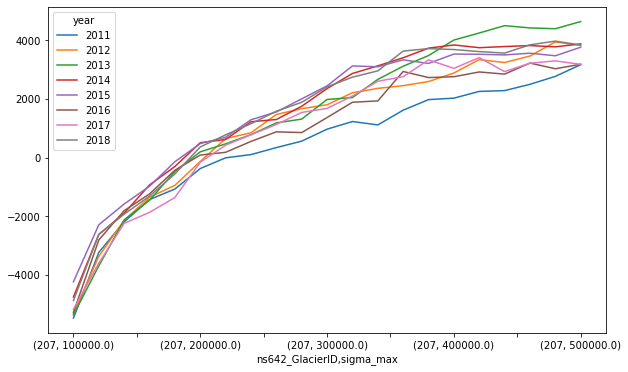

Rink Isbrae: type=CR  coast=CW
   Calving Ridge, independent of the presence of AW (warm Atlantic waters)
Adv/Ret rate (negative is retreat): -31.616168695486646 m/a
Undercut rate = 1.78


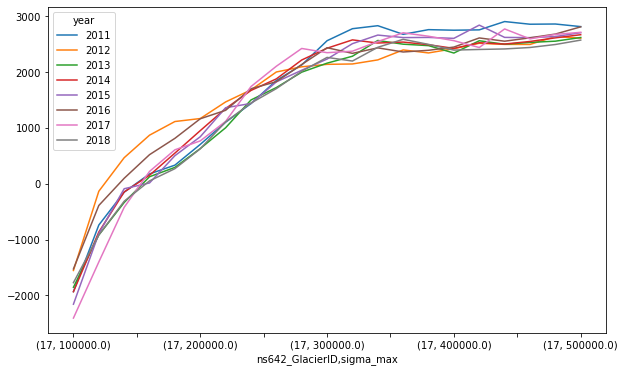

Ussing Br.: type=CR  coast=NW
   Calving Ridge, independent of the presence of AW (warm Atlantic waters)
Adv/Ret rate (negative is retreat): -26.06492216793804 m/a
Undercut rate = 0.88


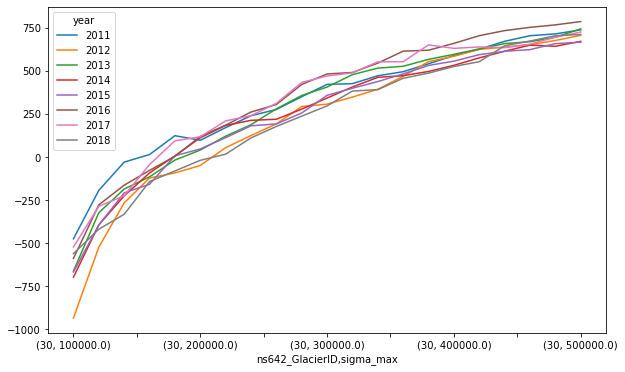

Upernavik Isstrom S: type=CR  coast=NW
   Calving Ridge, independent of the presence of AW (warm Atlantic waters)
Adv/Ret rate (negative is retreat): -19.585277298091906 m/a
Undercut rate = 1.03


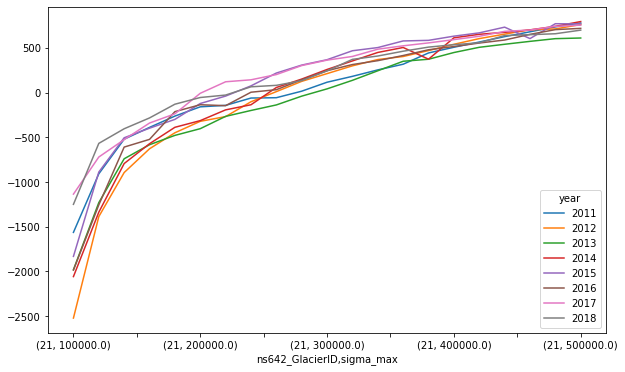

Skinfaxe Gl.: type=CR  coast=SE
   Calving Ridge, independent of the presence of AW (warm Atlantic waters)
Adv/Ret rate (negative is retreat): 0.24270305006108325 m/a
Undercut rate = 0.94


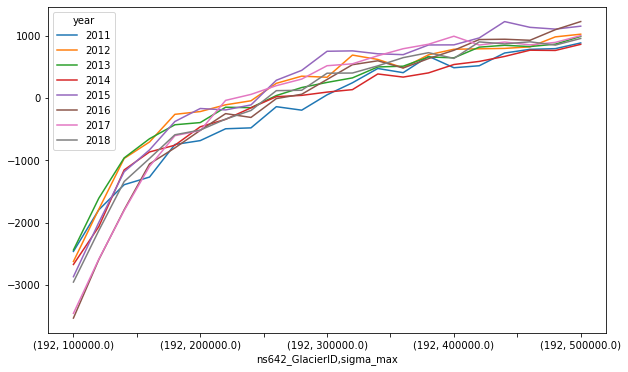

Rimfaxe Gl.: type=CR  coast=SE
   Calving Ridge, independent of the presence of AW (warm Atlantic waters)
Adv/Ret rate (negative is retreat): 2.304114049114043 m/a
Undercut rate = 1.06


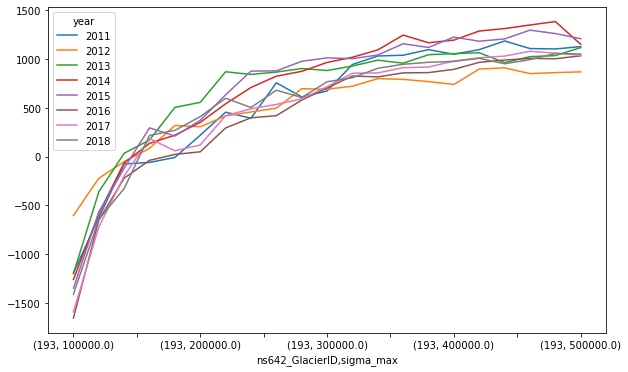

Store Gl.: type=CR  coast=CW
   Calving Ridge, independent of the presence of AW (warm Atlantic waters)
Adv/Ret rate (negative is retreat): 10.09250079372828 m/a
Undercut rate = 1.29


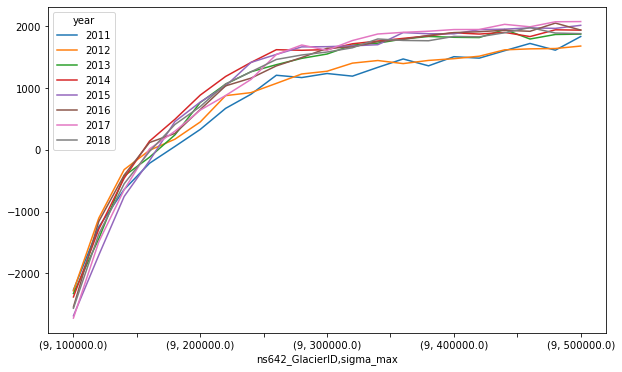

Upernavik Isstrom N: type=DW  coast=NW
   Terminating in deep warm water (DW) with the detected presence of AW (warm Atlantic waters)
Adv/Ret rate (negative is retreat): -3467.7840563719315 m/a
Undercut rate = 1.16


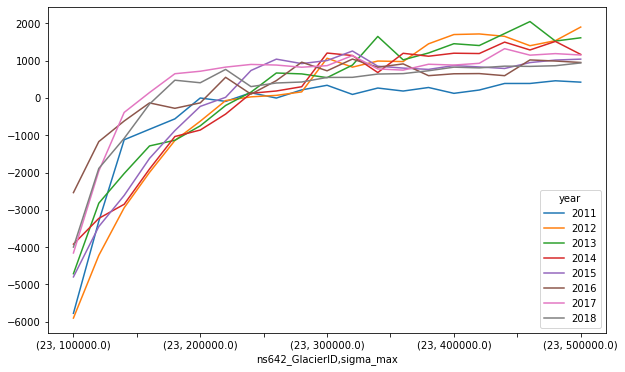

Upernavik Isstrom C: type=DW  coast=NW
   Terminating in deep warm water (DW) with the detected presence of AW (warm Atlantic waters)
Adv/Ret rate (negative is retreat): -314.7180507237756 m/a
Undercut rate = 1.27


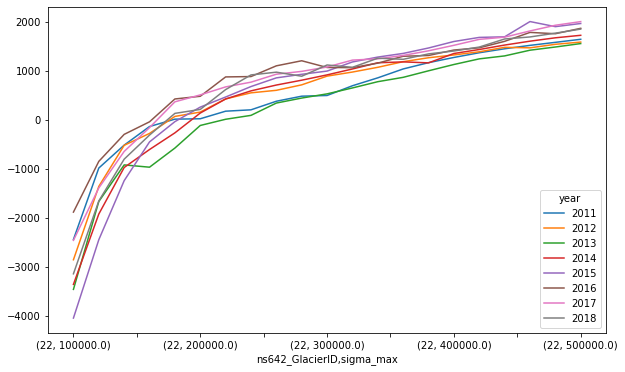

Kangerlussuaq Gl.: type=DW  coast=CE
   Terminating in deep warm water (DW) with the detected presence of AW (warm Atlantic waters)
Adv/Ret rate (negative is retreat): -304.0351566618488 m/a
Undercut rate = 1.1


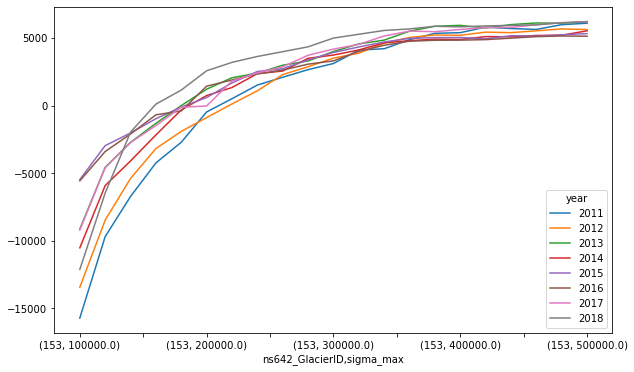

Helheim Gl.: type=DW  coast=SE
   Terminating in deep warm water (DW) with the detected presence of AW (warm Atlantic waters)
Adv/Ret rate (negative is retreat): -247.35865956155885 m/a
Undercut rate = 2.53


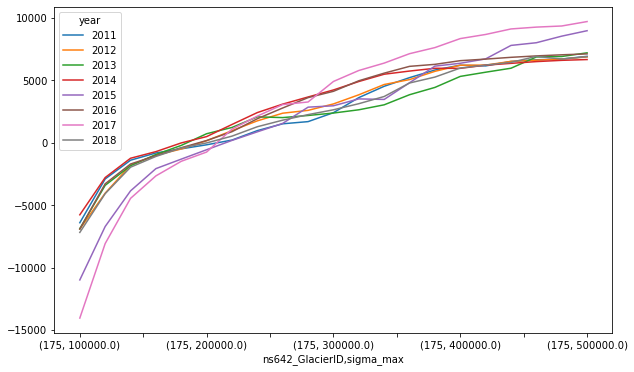

Perlerfiup Se.: type=DW  coast=CW
   Terminating in deep warm water (DW) with the detected presence of AW (warm Atlantic waters)
Adv/Ret rate (negative is retreat): -244.18724225111083 m/a
Undercut rate = 0.7


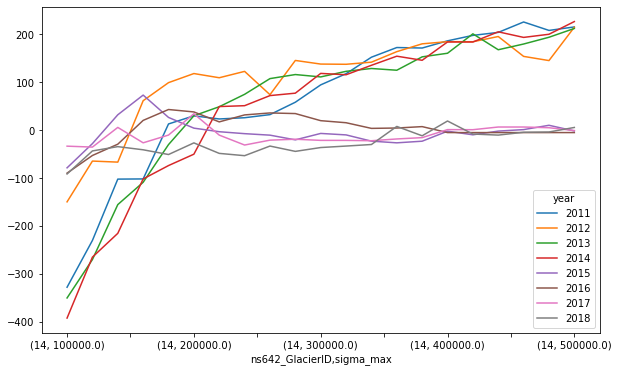

Kong Oscar Gl.: type=DW  coast=NW
   Terminating in deep warm water (DW) with the detected presence of AW (warm Atlantic waters)
Adv/Ret rate (negative is retreat): -113.01546454440378 m/a
Undercut rate = 1.43


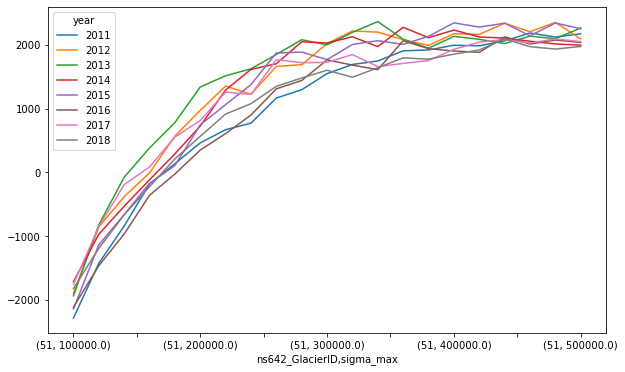

Koge Bugt Gl. C: type=DW  coast=SE
   Terminating in deep warm water (DW) with the detected presence of AW (warm Atlantic waters)
Adv/Ret rate (negative is retreat): -62.90999500940699 m/a
Undercut rate = 1.36


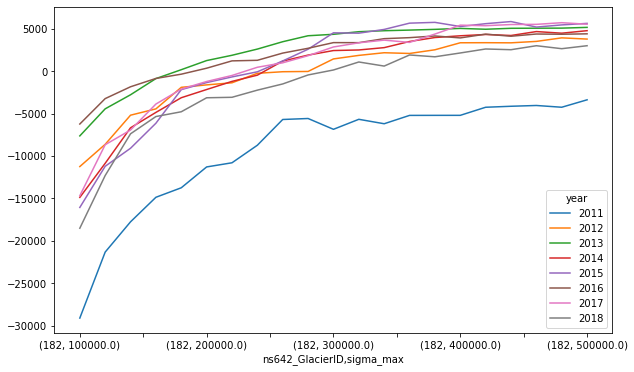

F. Graae Gl.: type=DW  coast=CE
   Terminating in deep warm water (DW) with the detected presence of AW (warm Atlantic waters)
Adv/Ret rate (negative is retreat): -62.792085322293595 m/a
Undercut rate = 0.73


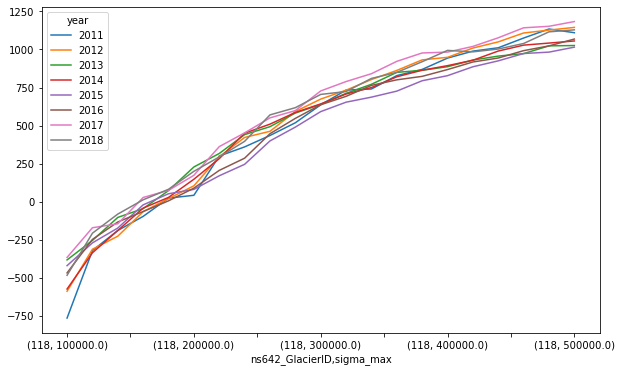

Jakobshavn Isbrae: type=FE  coast=CW
   Glacier with long (>10km) floating extension
Adv/Ret rate (negative is retreat): -595.0373776486698 m/a
Undercut rate = 2.16


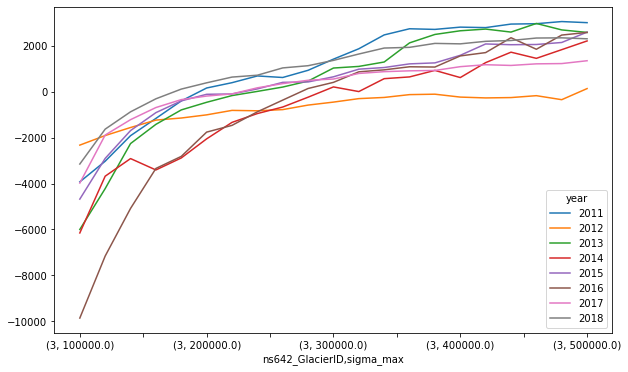

Deception O Gl. CN: type=NC  coast=CE
   Non-categorized due to lack of bathymetry and ocean temperature data
Adv/Ret rate (negative is retreat): -256.5288023945322 m/a
Undercut rate = 2.15


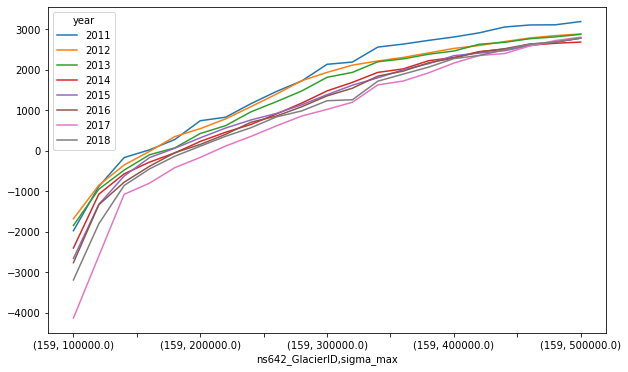

Sermeq Avannarleq: type=NC  coast=CW
   Non-categorized due to lack of bathymetry and ocean temperature data
Adv/Ret rate (negative is retreat): -15.842697317629234 m/a
Undercut rate = 0.48


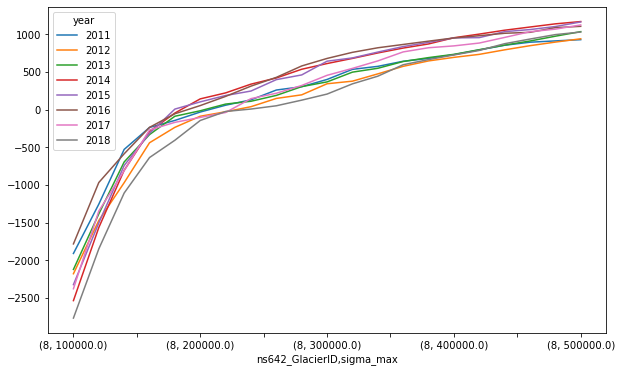

Morell Gl.: type=NC  coast=NW
   Non-categorized due to lack of bathymetry and ocean temperature data
Adv/Ret rate (negative is retreat): 93.56463961980424 m/a
Undercut rate = 0.51


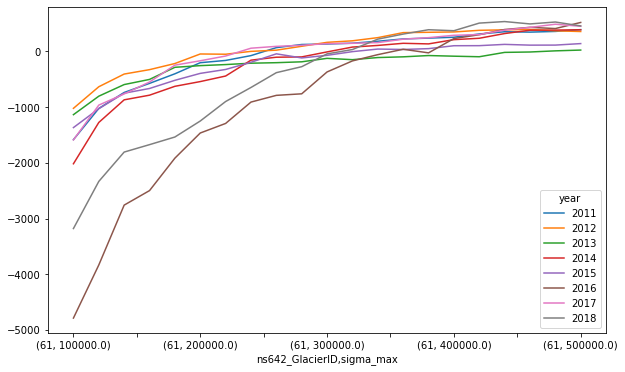

Nordenskiold Gl. N: type=SC  coast=NW
   stand in shallow cold (SC) (<100-m depth) fjords with polar water
Adv/Ret rate (negative is retreat): -776.6940185242654 m/a
Undercut rate = 0.37


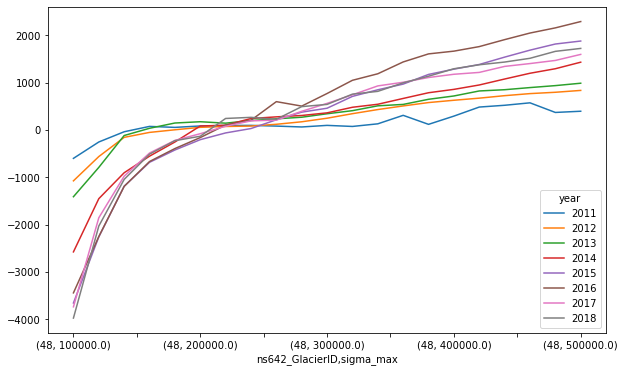

Farquhar Gl.: type=SC  coast=N
   stand in shallow cold (SC) (<100-m depth) fjords with polar water
Adv/Ret rate (negative is retreat): -136.6780307813108 m/a
Undercut rate = 0.34


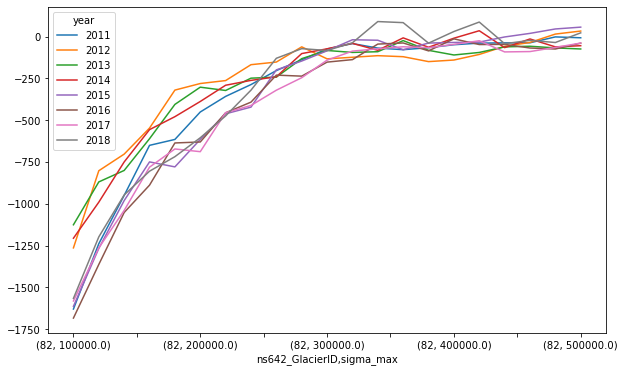

Kangilleq: type=SC  coast=CW
   stand in shallow cold (SC) (<100-m depth) fjords with polar water
Adv/Ret rate (negative is retreat): 10.350600985967528 m/a
Undercut rate = 0.8


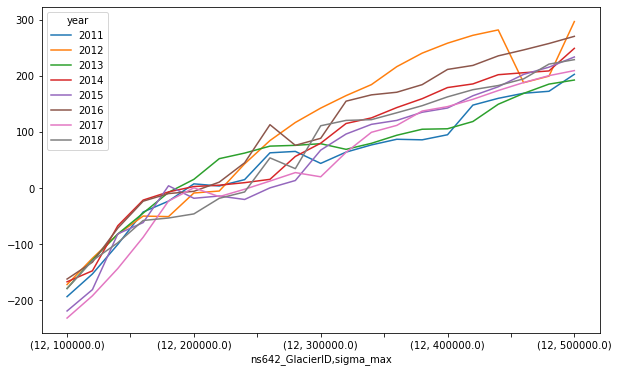

Ukaasorsuaq: type=SC  coast=SW
   stand in shallow cold (SC) (<100-m depth) fjords with polar water
Adv/Ret rate (negative is retreat): 17.423342840337934 m/a
Undercut rate = 0.9


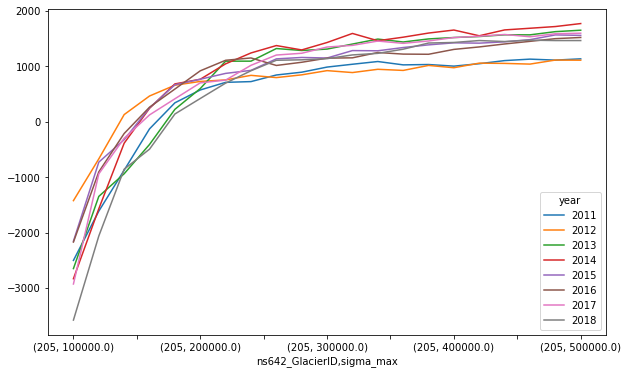

In [220]:
plotdfg = plotdf.groupby(['ns642_GlacierID'])

sorted = select.sort_values(['w21_category','retreat_rate'])
for ix,row in sorted.iterrows():
    name = row['w21_popular_name']
    retreat_rate = row['retreat_rate']

    plotdfx = plotdfg.get_group(row['ns642_GlacierID'])

    category = row['w21_category']
    #abc = row['poly_abc']

    print('{}: type={}  coast={}'.format(name, category, row['w21_coast']))
    print('   {}'.format(uafgi.data.w21.category_descr[category]))
    print('ns642 Adv/Ret rate: {} m/a'.format(retreat_rate))
    print('Undercut rate = {}'.format(row['w21_mean_undercutting_2008_2017']))
    #print('curvature {}'.format(abc[2] / abc[1]))
    plotdfx.plot(figsize=(10,6))
    plt.show()

#    break


In [175]:
xx=rs.groupby(['ns642_GlacierID']).agg({'sigma_eq': ['mean','std'], 'dadv_dsigma': ['mean','std']})
# https://stackoverflow.com/questions/14507794/pandas-how-to-flatten-a-hierarchical-index-in-columns
xx.columns = ['_'.join(col).strip() for col in xx.columns.values]
xx = xx.reset_index()


,ns642_GlacierID,sigma_eq_mean,sigma_eq_std,dadv_dsigma_mean,dadv_dsigma_std
0,3,229779.347053,39659.300169,0.019896,0.004665
1,8,206191.227822,11632.070378,0.010525,0.001852
2,9,167408.685798,3969.340982,0.024342,0.002880
3,12,209944.347226,15573.679955,0.001230,0.000181
4,14,331427.763838,151786.603029,0.001233,0.000903
5,17,153196.940863,9719.820395,0.026087,0.002289
6,21,229353.735876,17701.697950,0.006029,0.001189
7,22,188108.683149,15882.792063,0.017940,0.003927
8,23,236014.579558,83870.134186,0.018467,0.007158
9,30,185637.540691,13958.761711,0.004891,0.000465


Kangiata Nunaata Se.: type=CR  coast=SW
   Calving Ridge, independent of the presence of AW (warm Atlantic waters)
Adv/Ret rate (negative is retreat): -107.53448540724511 m/a
Undercut rate = 1.5
curvature -526368.2089074807


KeyError: 2017

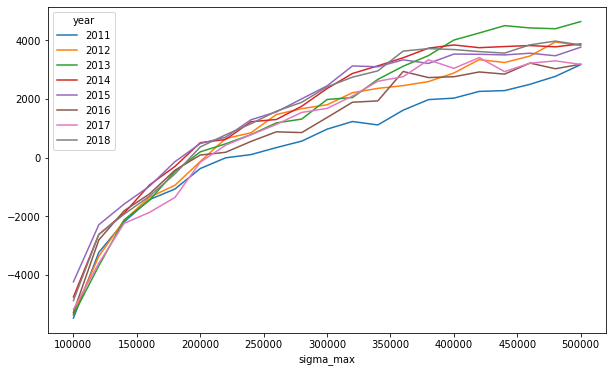

In [122]:
import matplotlib.pyplot as plt
df1g = df.groupby(['ns642_GlacierID'])
# Get first group for now
#print(df1g.get_group(17))
#for glacier_id,df2 in df1g:
sorted = select.sort_values(['w21_category','retreat_rate'])
for ix,row in sorted.iterrows():
    df2 = df1g.get_group(row['ns642_GlacierID'])
    name = row['w21_popular_name']
    retreat_rate = row['retreat_rate']
    year = 2017
    gs = glacier_stability(df2)
    gs.pivot(index='sigma_max', columns='year', values='advret_rate').plot(figsize=(10,6))


#    print(gs)
    category = row['w21_category']
    print('{}: type={}  coast={}'.format(name, category, row['w21_coast']))
    print('   {}'.format(uafgi.data.w21.category_descr[category]))
    print('Adv/Ret rate (negative is retreat): {} m/a'.format(retreat_rate))
    print('Undercut rate = {}'.format(row['w21_mean_undercutting_2008_2017']))
    print('curvature {}'.format(abc[2] / abc[1]))
    abc = np.polyfit(gs.index.to_list(), gs[year].to_list(), 3)
    ab = np.polyder(abc)     # Derivative of abc
    xp = np.linspace(100000,500000,30)
    poly = np.poly1d(abc)
    plt.plot(xp, poly(xp))
    roots = [np.real(x) for x in np.roots(abc) if ~np.iscomplex(x) and x >= 100000 and x <= 500000]
    root = roots[0] if len(roots) > 0 else 0
    slope = np.poly1d(ab)(root)
#    print('poly: ', abc)
    print('root={:1.0f}   slope={:1.3f} '.format(root, slope))
    
    plt.show()
    break
#    selrow = select[select['ns642_GlacierID'] == glacier_id]
#    name = selrow['w21_popular_name'].iloc[0]
#    retreat_rate = selrow['retreat_rate'].iloc[0]
#    print('{}: {}'.format(name,retreat_rate))
#    print(df2.iloc[0].w21_category)



In [69]:
gs

year,2011,2012,2013,2014,2015,2016,2017,2018
sigma_max,,,,,,,,
100000.0,-5477.850009,-5332.383198,-5368.110325,-4757.492336,-4241.341942,-5281.606167,-5181.223874,-4881.505205
120000.0,-3237.463683,-3369.344727,-3695.747396,-2624.813255,-2294.062615,-2812.277661,-3605.254678,-2623.503908
140000.0,-2195.359873,-2139.242656,-2128.788747,-1897.961005,-1586.497526,-1814.261904,-2244.205872,-1932.263034
160000.0,-1433.046378,-1353.783920,-1458.023588,-934.572107,-978.454419,-1240.718345,-1870.558177,-1315.976456
180000.0,-1074.588501,-947.362735,-473.199018,-304.989689,-141.861488,-433.851952,-1362.328633,-558.962757
200000.0,-374.873931,-133.930475,194.868650,506.791777,477.999690,85.579171,-159.209526,362.138020
220000.0,-8.958016,646.853596,468.031506,617.066564,693.799880,179.722488,423.110675,775.562700
240000.0,101.206718,846.039638,782.451852,1222.535739,1290.039702,550.603920,777.911464,1155.068573
260000.0,339.948237,1469.604286,1182.889010,1298.536960,1556.651935,878.331842,1129.739284,1581.360530


In [24]:
import datetime
datetime.datetime(dt)

TypeError: an integer is required (got type real_datetime)

In [35]:
dt

real_datetime(2011, 1, 1, 0, 0)

In [27]:
dt.astype('datetime64[ns]')

AttributeError: 'real_datetime' object has no attribute 'astype'